In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from keras import backend as K 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec

Using TensorFlow backend.


In [2]:
data = pd.read_csv('tatarstan_message_2.csv', sep = ';')
print(data.columns)
data = data[['categories', 'description_stem']]
data.head(3)

Index(['Unnamed: 0', 'categories', 'description', 'description_prep',
       'description_stem'],
      dtype='object')


,categories,description_stem
0,Благоустройство территории,трасса нижнекамск чистополь лесополоса пгт кам...
1,Благоустройство территории,двор дом ленинградский отсутствовать парковочн...
2,Содержание и ремонт муниципальных дорог,добрый день осуществляться уборка снег центр г...


In [3]:
data = data.dropna()
text_train = data['description_stem'].to_list()

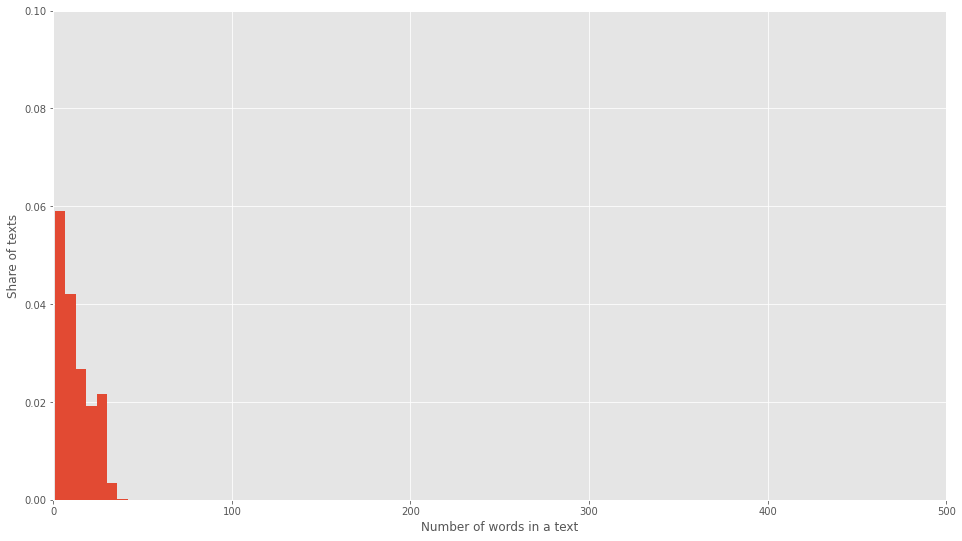

In [4]:
#гистограмма наиболее часто встречающегося количества слов
plt.style.use('ggplot')

plt.figure(figsize=(16, 9)) 
# facecolor='g'
len_of_sent = data['description_stem'].apply(lambda x: len(x.split(' ')))
n, bins, patches = plt.hist(len_of_sent, 500, density=True)
plt.xlabel('Number of words in a text')
plt.ylabel('Share of texts')
plt.axis([0, 500, 0, 0.1])
plt.grid(True)
plt.show()

#выбираем количество анализируемых слов = 30

In [5]:
#загрузка модели Word2Vec
model = Word2Vec.load("tweets_model.w2v")
model.delete_temporary_training_data()

In [6]:
#загрузка эмбеддингов из словаря модели
e_matrix = []
mydict = []
for word in model.wv.vocab.keys():
    try:
        e_matrix.append(model.wv[word])
        mydict.append(word)
        if len(e_matrix) >= 600000:
            break
    except:
        print("Пропущено слово при заполнении модели")
        continue

print(f"Размерность словаря для embedding {len(e_matrix)}")

NUM = len(e_matrix)
e_matrix = np.array(e_matrix, dtype=object)

Размерность словаря для embedding 600000


In [7]:
DIM = model.vector_size
tokenizer = Tokenizer(oov_token = True) #num_words = NUM
tokenizer.fit_on_texts(mydict)

SENTENCE_LENGTH = 30

print("подготовка обучающего набора")
raw_data = [row.split(' ') for row in data['description_stem']]
X = tokenizer.texts_to_sequences(raw_data) 
X = pad_sequences(X, maxlen=SENTENCE_LENGTH)
print(f"Количество слов в предложении: {len(X[0])}")
print(X.shape)
print(X)

Y = pd.get_dummies(data['categories'])
label_columns=Y.columns #To get the classes
Y = Y.to_numpy() #Convert labels to numpy array
print(Y.shape)
print(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

подготовка обучающего набора
Количество слов в предложении: 30
(28015, 30)
[[    0     0     0 ... 44432 30966 81127]
 [    0     0 16953 ...  5839  5959   594]
 [    0     0     0 ... 81127  2522 84833]
 ...
 [    0     0     0 ...     0 26641 26077]
 [    0     0  5638 ... 39383 35712  9499]
 [65932    67     1 ... 23944     1  9070]]
(28015, 36)
[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [8]:
# Метрики 
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [11]:
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout, LSTM
from keras.models import Model


tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32')
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH,
                          weights=[e_matrix], trainable=False)(tweet_input)
layer = LSTM(64)(tweet_encoder)
layer = Dense(256,name='FC1')(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(36,name='out_layer')(layer)
layer = Activation('softmax')(layer)
model = Model(tweet_input,outputs=layer)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1])
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 30)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 30, 200)           120000000 
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                67840     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 36)                9252

In [12]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("CNN_Word2Vec_LSTM-{epoch:02d}-{val_f1:.2f}.hdf5", # Сохраняем модель с лучшим val_f1
                             monitor='val_f1', save_best_only=True, mode='max', period=1)
history = model.fit(X_train, Y_train, batch_size=32, epochs=200, validation_split=0.2, callbacks = [checkpoint])

Train on 17929 samples, validate on 4483 samples
Epoch 1/200
17929/17929 [==============================] - 9s 524us/step - loss: 0.0570 - accuracy: 0.9796 - precision: 0.6744 - recall: 0.4669 - f1: 0.5463 - val_loss: 0.0469 - val_accuracy: 0.9831 - val_precision: 0.7544 - val_recall: 0.5834 - val_f1: 0.6566
Epoch 2/200
17929/17929 [==============================] - 9s 487us/step - loss: 0.0427 - accuracy: 0.9844 - precision: 0.7704 - recall: 0.6266 - f1: 0.6896 - val_loss: 0.0423 - val_accuracy: 0.9848 - val_precision: 0.7552 - val_recall: 0.6698 - val_f1: 0.7091
Epoch 3/200
17929/17929 [==============================] - 9s 488us/step - loss: 0.0366 - accuracy: 0.9865 - precision: 0.7976 - recall: 0.6889 - f1: 0.7382 - val_loss: 0.0397 - val_accuracy: 0.9853 - val_precision: 0.7772 - val_recall: 0.6616 - val_f1: 0.7137
Epoch 4/200
17929/17929 [==============================] - 9s 507us/step - loss: 0.0324 - accuracy: 0.9882 - precision: 0.8192 - recall: 0.7356 - f1: 0.7745 - val_loss:

17929/17929 [==============================] - 8s 474us/step - loss: 0.0071 - accuracy: 0.9974 - precision: 0.9596 - recall: 0.9445 - f1: 0.9519 - val_loss: 0.0872 - val_accuracy: 0.9845 - val_precision: 0.7282 - val_recall: 0.7101 - val_f1: 0.7189
Epoch 33/200
17929/17929 [==============================] - 8s 466us/step - loss: 0.0067 - accuracy: 0.9975 - precision: 0.9626 - recall: 0.9474 - f1: 0.9548 - val_loss: 0.0941 - val_accuracy: 0.9846 - val_precision: 0.7268 - val_recall: 0.7137 - val_f1: 0.7201
Epoch 34/200
17929/17929 [==============================] - 8s 472us/step - loss: 0.0062 - accuracy: 0.9978 - precision: 0.9662 - recall: 0.9537 - f1: 0.9598 - val_loss: 0.0940 - val_accuracy: 0.9849 - val_precision: 0.7365 - val_recall: 0.7176 - val_f1: 0.7268
Epoch 35/200
17929/17929 [==============================] - 8s 468us/step - loss: 0.0060 - accuracy: 0.9978 - precision: 0.9659 - recall: 0.9542 - f1: 0.9599 - val_loss: 0.0950 - val_accuracy: 0.9842 - val_precision: 0.7232 - v

17929/17929 [==============================] - 8s 464us/step - loss: 0.0047 - accuracy: 0.9982 - precision: 0.9715 - recall: 0.9625 - f1: 0.9669 - val_loss: 0.1088 - val_accuracy: 0.9845 - val_precision: 0.7253 - val_recall: 0.7111 - val_f1: 0.7180
Epoch 64/200
17929/17929 [==============================] - 8s 471us/step - loss: 0.0050 - accuracy: 0.9981 - precision: 0.9715 - recall: 0.9615 - f1: 0.9664 - val_loss: 0.1071 - val_accuracy: 0.9841 - val_precision: 0.7169 - val_recall: 0.7073 - val_f1: 0.7120
Epoch 65/200
17929/17929 [==============================] - 8s 463us/step - loss: 0.0055 - accuracy: 0.9980 - precision: 0.9686 - recall: 0.9585 - f1: 0.9634 - val_loss: 0.1086 - val_accuracy: 0.9842 - val_precision: 0.7204 - val_recall: 0.7044 - val_f1: 0.7122
Epoch 66/200
17929/17929 [==============================] - 8s 470us/step - loss: 0.0047 - accuracy: 0.9983 - precision: 0.9742 - recall: 0.9641 - f1: 0.9690 - val_loss: 0.1115 - val_accuracy: 0.9846 - val_precision: 0.7255 - v

17929/17929 [==============================] - 9s 509us/step - loss: 0.0043 - accuracy: 0.9984 - precision: 0.9752 - recall: 0.9669 - f1: 0.9710 - val_loss: 0.1197 - val_accuracy: 0.9845 - val_precision: 0.7251 - val_recall: 0.7111 - val_f1: 0.7179
Epoch 95/200
17929/17929 [==============================] - 9s 514us/step - loss: 0.0046 - accuracy: 0.9983 - precision: 0.9742 - recall: 0.9637 - f1: 0.9688 - val_loss: 0.1201 - val_accuracy: 0.9845 - val_precision: 0.7255 - val_recall: 0.7124 - val_f1: 0.7188
Epoch 96/200
17929/17929 [==============================] - 9s 525us/step - loss: 0.0046 - accuracy: 0.9984 - precision: 0.9747 - recall: 0.9659 - f1: 0.9702 - val_loss: 0.1177 - val_accuracy: 0.9845 - val_precision: 0.7268 - val_recall: 0.7132 - val_f1: 0.7198
Epoch 97/200
17929/17929 [==============================] - 9s 499us/step - loss: 0.0040 - accuracy: 0.9985 - precision: 0.9765 - recall: 0.9680 - f1: 0.9722 - val_loss: 0.1227 - val_accuracy: 0.9844 - val_precision: 0.7216 - v

17929/17929 [==============================] - 9s 500us/step - loss: 0.0041 - accuracy: 0.9985 - precision: 0.9761 - recall: 0.9682 - f1: 0.9721 - val_loss: 0.1279 - val_accuracy: 0.9846 - val_precision: 0.7246 - val_recall: 0.7159 - val_f1: 0.7202
Epoch 126/200
17929/17929 [==============================] - 9s 507us/step - loss: 0.0042 - accuracy: 0.9985 - precision: 0.9755 - recall: 0.9688 - f1: 0.9721 - val_loss: 0.1286 - val_accuracy: 0.9840 - val_precision: 0.7137 - val_recall: 0.7069 - val_f1: 0.7102
Epoch 127/200
17929/17929 [==============================] - 9s 515us/step - loss: 0.0043 - accuracy: 0.9984 - precision: 0.9757 - recall: 0.9675 - f1: 0.9716 - val_loss: 0.1285 - val_accuracy: 0.9844 - val_precision: 0.7216 - val_recall: 0.7113 - val_f1: 0.7163
Epoch 128/200
17929/17929 [==============================] - 9s 517us/step - loss: 0.0039 - accuracy: 0.9984 - precision: 0.9760 - recall: 0.9675 - f1: 0.9717 - val_loss: 0.1264 - val_accuracy: 0.9846 - val_precision: 0.7256 

17929/17929 [==============================] - 9s 515us/step - loss: 0.0037 - accuracy: 0.9986 - precision: 0.9776 - recall: 0.9709 - f1: 0.9742 - val_loss: 0.1297 - val_accuracy: 0.9844 - val_precision: 0.7205 - val_recall: 0.7144 - val_f1: 0.7174
Epoch 157/200
17929/17929 [==============================] - 9s 508us/step - loss: 0.0039 - accuracy: 0.9985 - precision: 0.9764 - recall: 0.9696 - f1: 0.9729 - val_loss: 0.1288 - val_accuracy: 0.9842 - val_precision: 0.7187 - val_recall: 0.7069 - val_f1: 0.7127
Epoch 158/200
17929/17929 [==============================] - 9s 503us/step - loss: 0.0039 - accuracy: 0.9985 - precision: 0.9767 - recall: 0.9694 - f1: 0.9729 - val_loss: 0.1282 - val_accuracy: 0.9844 - val_precision: 0.7220 - val_recall: 0.7106 - val_f1: 0.7162
Epoch 159/200
17929/17929 [==============================] - 9s 512us/step - loss: 0.0045 - accuracy: 0.9983 - precision: 0.9740 - recall: 0.9658 - f1: 0.9698 - val_loss: 0.1264 - val_accuracy: 0.9842 - val_precision: 0.7186 

Epoch 187/200
17929/17929 [==============================] - 9s 511us/step - loss: 0.0036 - accuracy: 0.9986 - precision: 0.9783 - recall: 0.9699 - f1: 0.9740 - val_loss: 0.1289 - val_accuracy: 0.9847 - val_precision: 0.7262 - val_recall: 0.7208 - val_f1: 0.7235
Epoch 188/200
17929/17929 [==============================] - 9s 503us/step - loss: 0.0039 - accuracy: 0.9985 - precision: 0.9780 - recall: 0.9690 - f1: 0.9734 - val_loss: 0.1286 - val_accuracy: 0.9848 - val_precision: 0.7295 - val_recall: 0.7186 - val_f1: 0.7239
Epoch 189/200
17929/17929 [==============================] - 9s 517us/step - loss: 0.0037 - accuracy: 0.9986 - precision: 0.9787 - recall: 0.9708 - f1: 0.9747 - val_loss: 0.1288 - val_accuracy: 0.9848 - val_precision: 0.7278 - val_recall: 0.7224 - val_f1: 0.7250
Epoch 190/200
17929/17929 [==============================] - 9s 503us/step - loss: 0.0036 - accuracy: 0.9986 - precision: 0.9789 - recall: 0.9711 - f1: 0.9749 - val_loss: 0.1278 - val_accuracy: 0.9851 - val_prec

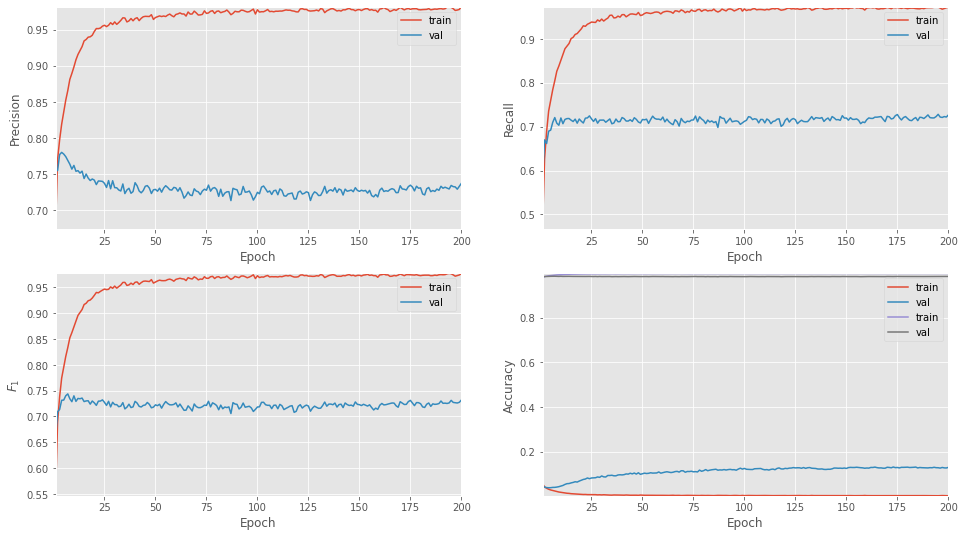

In [13]:
plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')
    plot_metrix(ax4, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

    plt.show()


plot_history(history)

In [18]:
model.load_weights('CNN_Word2Vec_LSTM-07-0.74.hdf5')

In [19]:
from sklearn.metrics import classification_report
print("Оценки тестового набора:")
predicted = np.round(model.predict(X_test))
print(classification_report(Y_test, predicted, digits=3))

Оценки тестового набора:
              precision    recall  f1-score   support

           0      0.793     0.307     0.442        75
           1      0.976     0.795     0.876       156
           2      0.766     0.800     0.783      2604
           3      0.000     0.000     0.000         6
           4      1.000     0.235     0.381        34
           5      0.167     0.059     0.087        17
           6      0.000     0.000     0.000         1
           7      0.000     0.000     0.000        15
           8      0.000     0.000     0.000         4
           9      0.417     0.217     0.286        23
          10      0.000     0.000     0.000         3
          11      0.952     0.606     0.741        33
          12      0.907     0.841     0.872       439
          13      0.000     0.000     0.000         0
          14      0.000     0.000     0.000         1
          15      0.000     0.000     0.000         2
          16      0.789     0.577     0.667       175
  

C:\Anaconda\envs\python_37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\envs\python_37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\envs\python_37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from keras import optimizers

model.layers[1].trainable = True
adam = optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[precision, recall, f1])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 30)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 30, 200)           120000000 
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                67840     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 36)                9252

In [21]:
checkpoint = ModelCheckpoint("CNN_Word2Vec_LSTM_add-training-{epoch:02d}-{val_f1:.2f}.hdf5", 
                             monitor='val_f1', save_best_only=True, mode='max', period=1)

history_trainable = model.fit(X_train, Y_train, batch_size=32, epochs=20, validation_split=0.25, callbacks = [checkpoint])

C:\Anaconda\envs\python_37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16809 samples, validate on 5603 samples
Epoch 1/20
16809/16809 [==============================] - 980s 58ms/step - loss: 0.0196 - precision: 0.8990 - recall: 0.8481 - f1: 0.8724 - val_loss: 0.0356 - val_precision: 0.8103 - val_recall: 0.7614 - val_f1: 0.7847
Epoch 2/20
16809/16809 [==============================] - 972s 58ms/step - loss: 0.0175 - precision: 0.9103 - recall: 0.8647 - f1: 0.8865 - val_loss: 0.0359 - val_precision: 0.8109 - val_recall: 0.7658 - val_f1: 0.7874
Epoch 3/20
16809/16809 [==============================] - 965s 57ms/step - loss: 0.0161 - precision: 0.9197 - recall: 0.8759 - f1: 0.8969 - val_loss: 0.0362 - val_precision: 0.8139 - val_recall: 0.7711 - val_f1: 0.7916
Epoch 4/20
16809/16809 [==============================] - 966s 57ms/step - loss: 0.0150 - precision: 0.9271 - recall: 0.8868 - f1: 0.9062 - val_loss: 0.0367 - val_precision: 0.8133 - val_recall: 0.7741 - val_f1: 0.7929
Epoch 5/20
16809/16809 [==============================] - 966s 57ms/step - 

KeyError: 'accuracy'

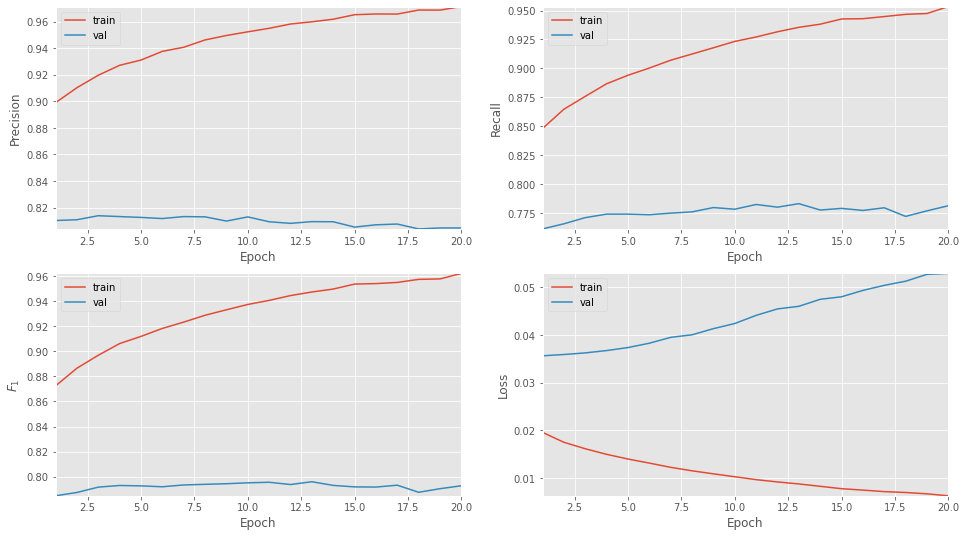

In [22]:
plot_history(history_trainable)